### This example demonstrates inferring gene programs using cNMF. In this example we will run cNMF in a step-wise manner and choose optimal hyper-parameters at each stage. For an example of running program inference for a range of parameters using config files checkout the factor analysis demo.

In [1]:
import os
import sys

sys.path.append('../../../../src/')
from inference import run_consensus_NMF, run_consensus_NMF_, run_cnmf_factorization, run_cnmf_consensus, init_cnmf_obj,\
                           compile_results, get_top_indices_fast, annotate_genes_to_excel

import anndata
import mudata

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### We will run cNMF with multiple values for the number of programs K and choose the optimal value via evaluations

In [10]:
# define parmaters
mode = "torch_cnmf"                                                                                                    #mode to use 
output_directory = "/oak/stanford/groups/engreitz/Users/ymo/Tools/gene_network_evaluation/src/inference/consensus_NMF" #output folder
run_name = "Test"                                                                                                      #output cnmf folder
counts_fn ="/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Cell_data/500_cell.h5ad"                       #data path 
n_iter=10
init="random"
algo="halsvar"
beta_loss='frobenius'
num_highvar_genes=2000
seed=14
total_workers=-1
sel_thresh=[0.2, 2.0]
components=[5,10,15]

# torch_cnmf specific parameters
use_gpu=True
batch_mode = "batch"
online_chunk_size=5000
tol = 1e-4
shuffle_cells=False
sk_cd_refit=True


In [11]:
# if use torch_cnmf, check GPU availablility

import torch

# Check if CUDA is available
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Get current GPU details
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")

CUDA Available: True
CUDA Version: 12.4
Number of GPUs: 1
Current GPU: NVIDIA L40S
Memory Allocated: 8.12 MB
Memory Reserved: 22.00 MB


In [12]:
# Run cNMF 

# Factorize data for different components
cnmf_obj = run_cnmf_factorization(  mode=mode,
                                    output_dir=output_directory, 
                                    run_name =run_name,
                                    counts_fn=counts_fn,
                                    components=components, 
                                    n_iter=n_iter, 
                                    init=init,
                                    algo=algo,
                                    beta_loss=beta_loss,
                                    num_highvar_genes=num_highvar_genes, 
                                    seed=seed,
                                    total_workers=total_workers, 
                                    sel_thresh=sel_thresh,
                                    tol=tol,
                                
                                # torch_cnmf specific parameters
                                    use_gpu=use_gpu,
                                    batch_mode = batch_mode,
                                    shuffle_cells=False,
                                    sk_cd_refit=True)

[Worker 0]. Starting task 0.
Use GPU mode.
 niter=10, loss=971.9623996071041.
 niter=20, loss=971.3804046947828.
 niter=30, loss=971.1328999549959.
 niter=40, loss=971.1309129051551.
    Converged after 40 iteration(s).
[Worker 0]. Starting task 1.
Use GPU mode.
 niter=10, loss=971.1722861444307.
 niter=20, loss=971.1309611736204.
    Converged after 20 iteration(s).
[Worker 0]. Starting task 2.
Use GPU mode.
 niter=10, loss=972.6633860179995.
 niter=20, loss=972.1736116815762.
 niter=30, loss=971.554673899004.
 niter=40, loss=971.1462058438987.
 niter=50, loss=971.1309692183645.
    Converged after 50 iteration(s).
[Worker 0]. Starting task 3.
Use GPU mode.
 niter=10, loss=972.2263994949942.
 niter=20, loss=971.3169137181746.
 niter=30, loss=971.1309933525961.
 niter=40, loss=971.1308968156661.
    Converged after 40 iteration(s).
[Worker 0]. Starting task 4.
Use GPU mode.
 niter=10, loss=972.072769266787.
 niter=20, loss=971.9603660257964.
 niter=30, loss=971.9569901106736.
    Conve

In [13]:
# Get current GPU details
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")

Current GPU: NVIDIA L40S
Memory Allocated: 8.12 MB
Memory Reserved: 22.00 MB


#### In the tradeoff b/w stability and error, the k at the first cross over is preferred


Combining factorizations for k=5.
Combining factorizations for k=10.
Combining factorizations for k=15.


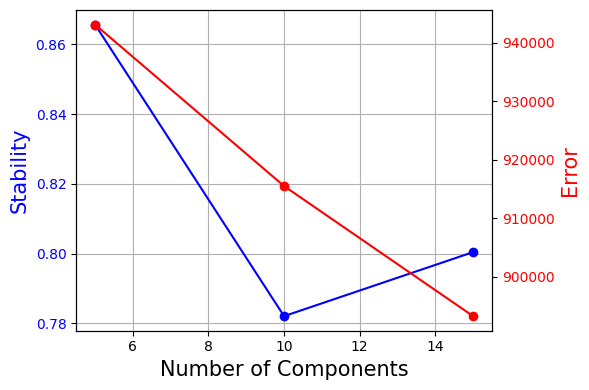

In [6]:
# Combine outputs
cnmf_obj.combine()

# Plot stability vs error
cnmf_obj.k_selection_plot()

Running cNMF: 100%|██████████| 3/3 [00:09<00:00,  3.15s/it]


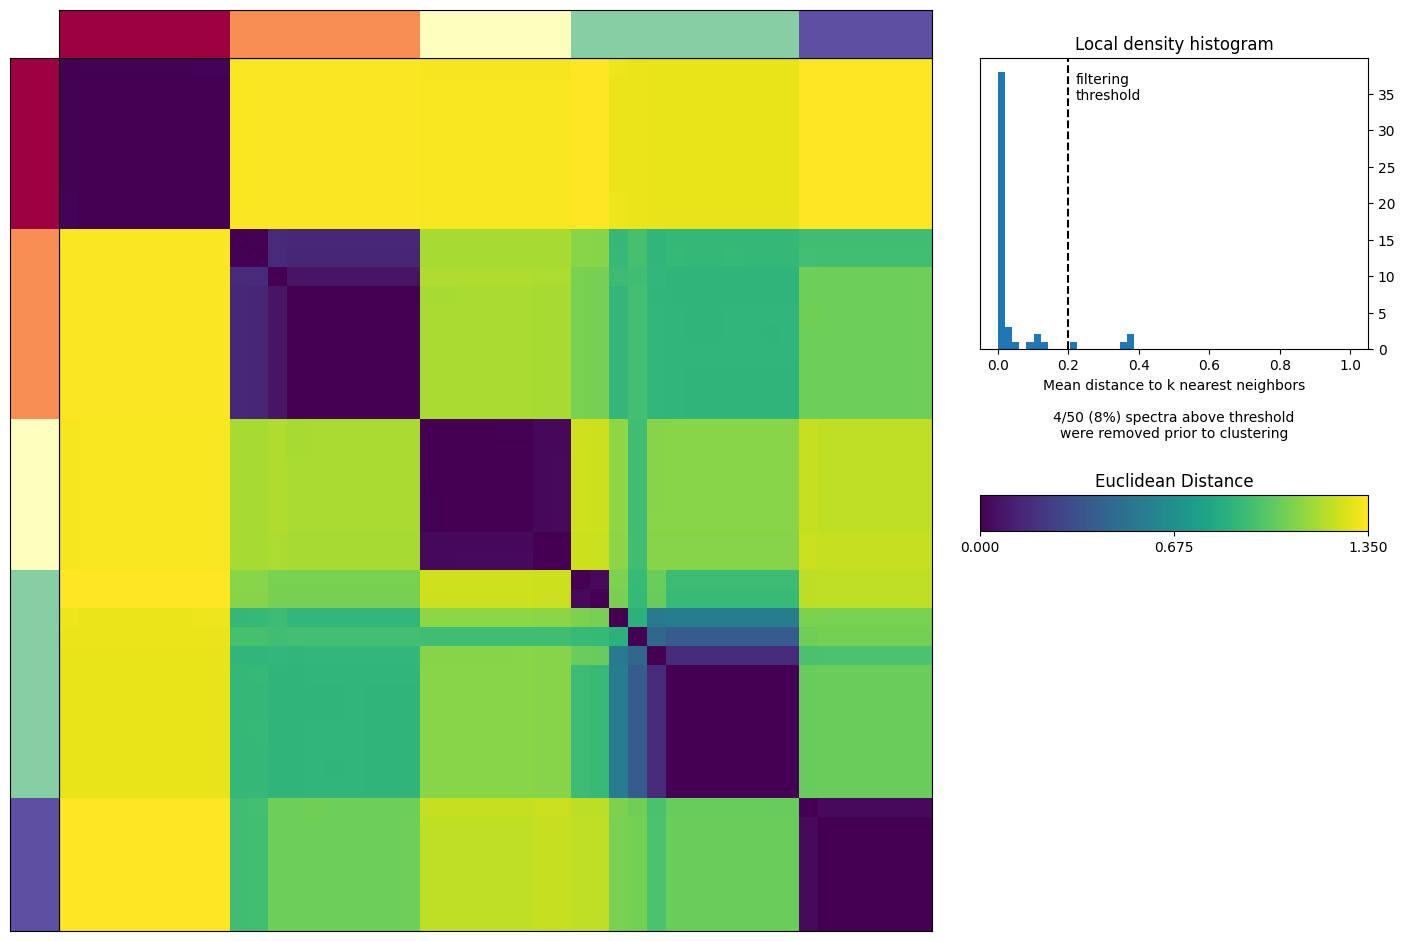

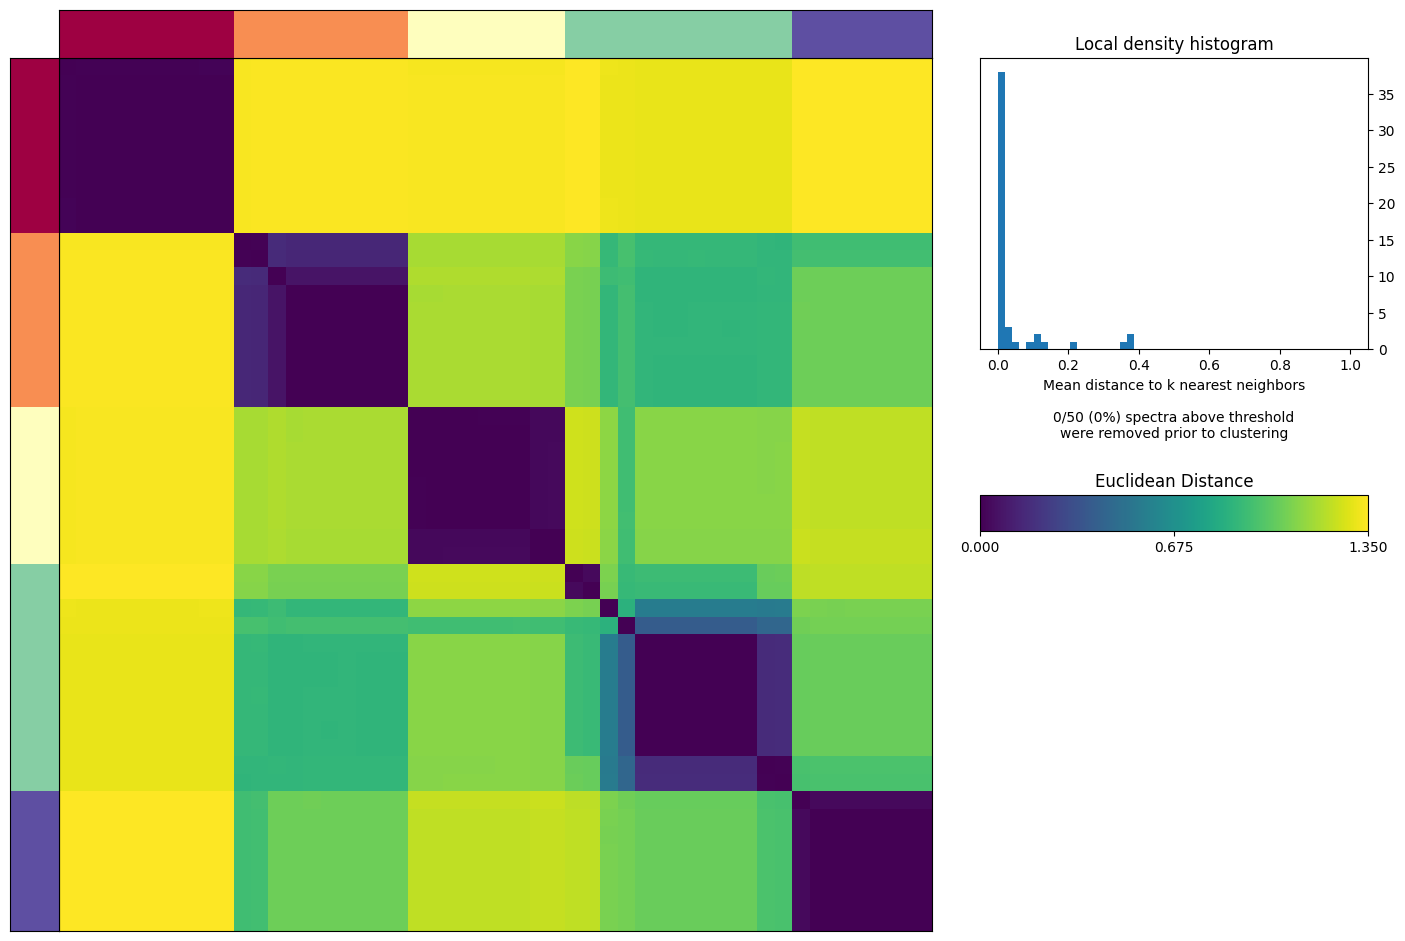

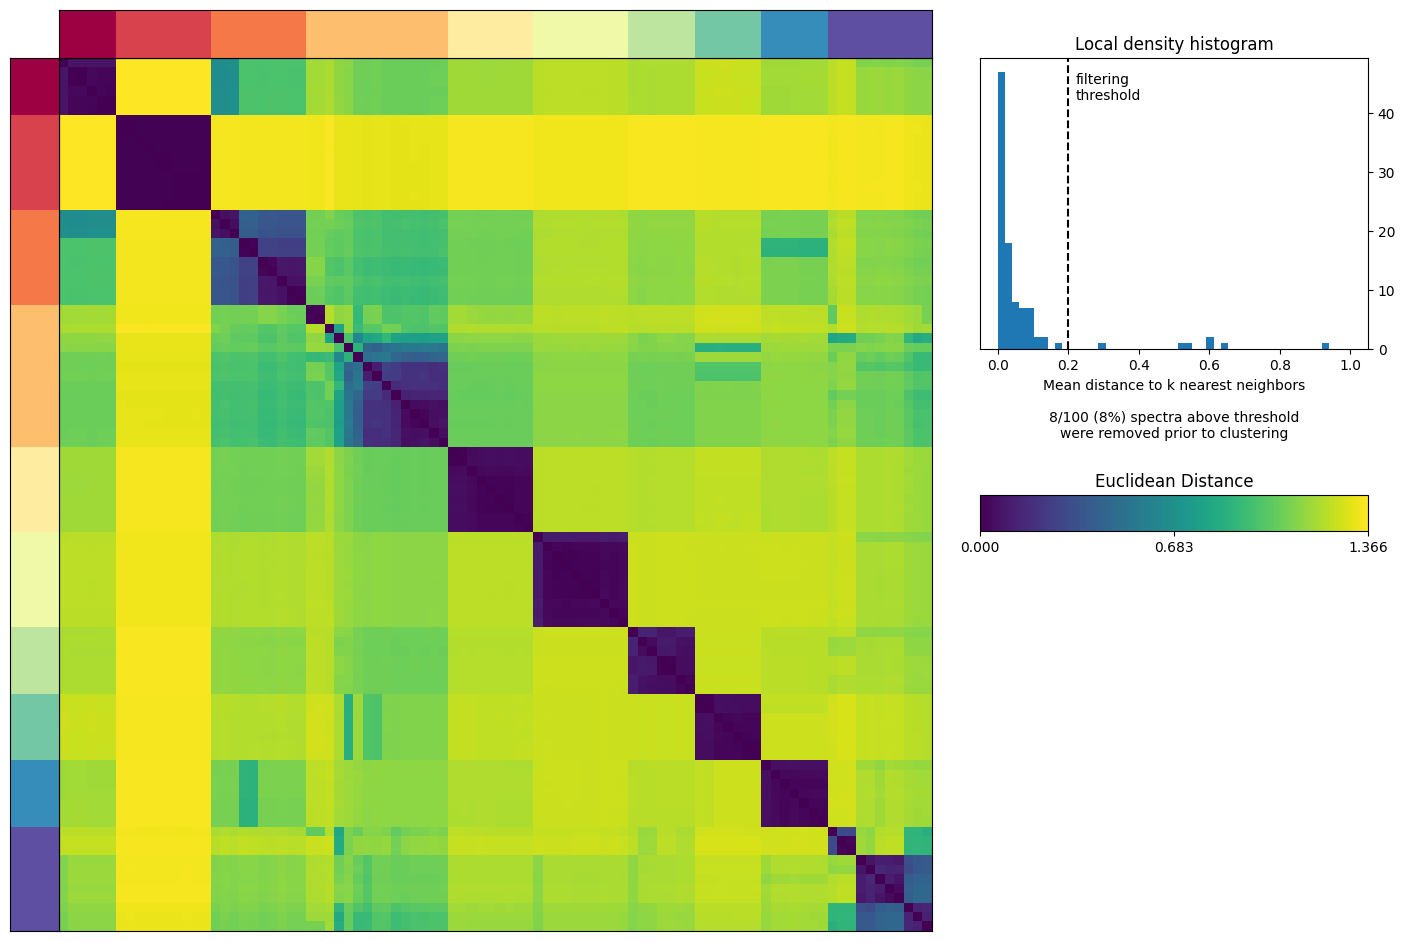

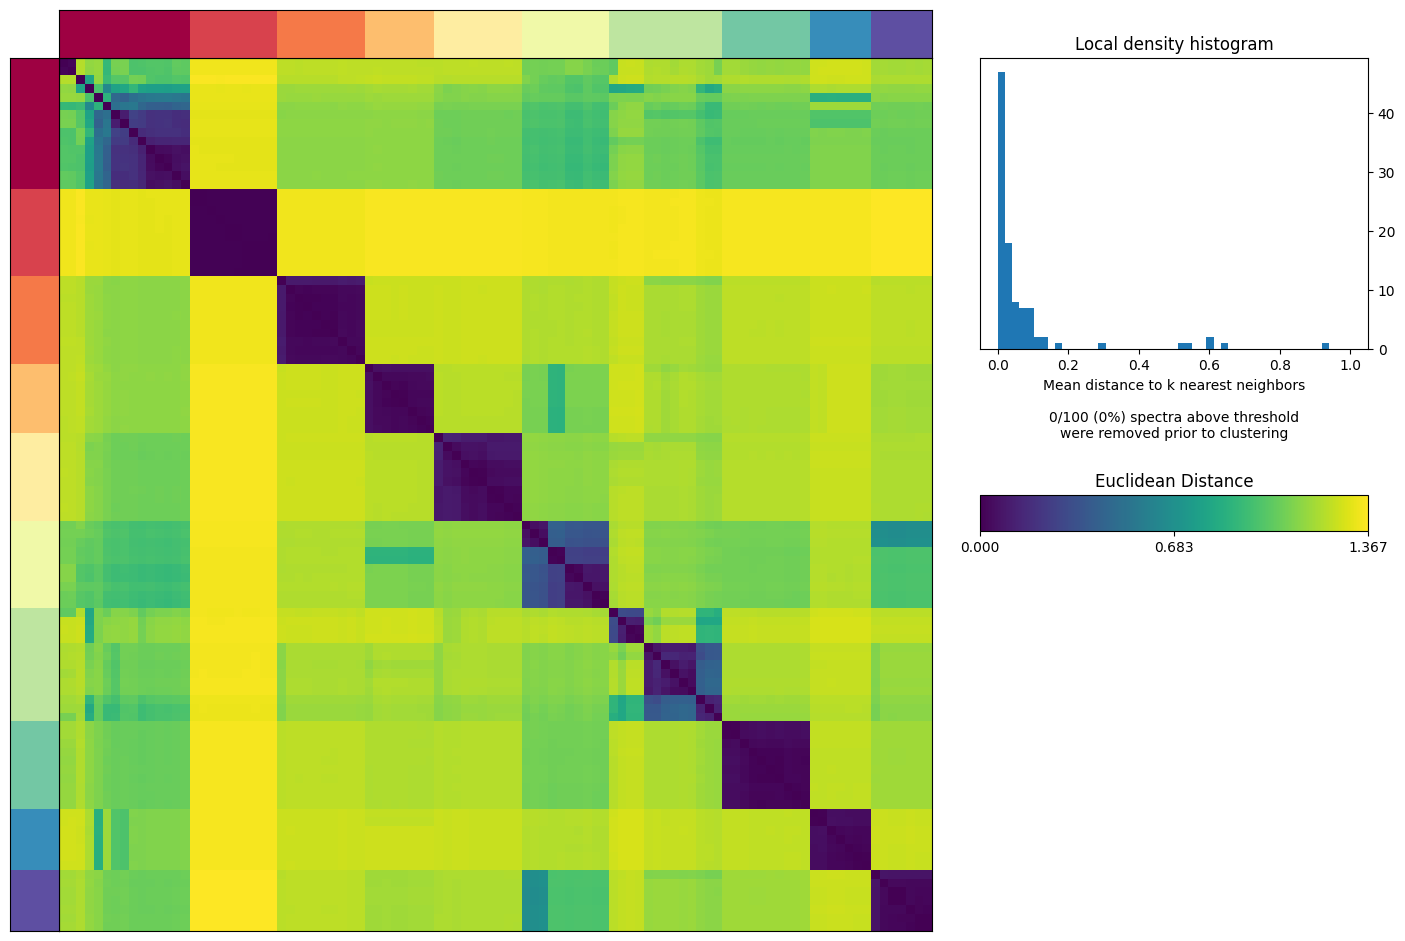

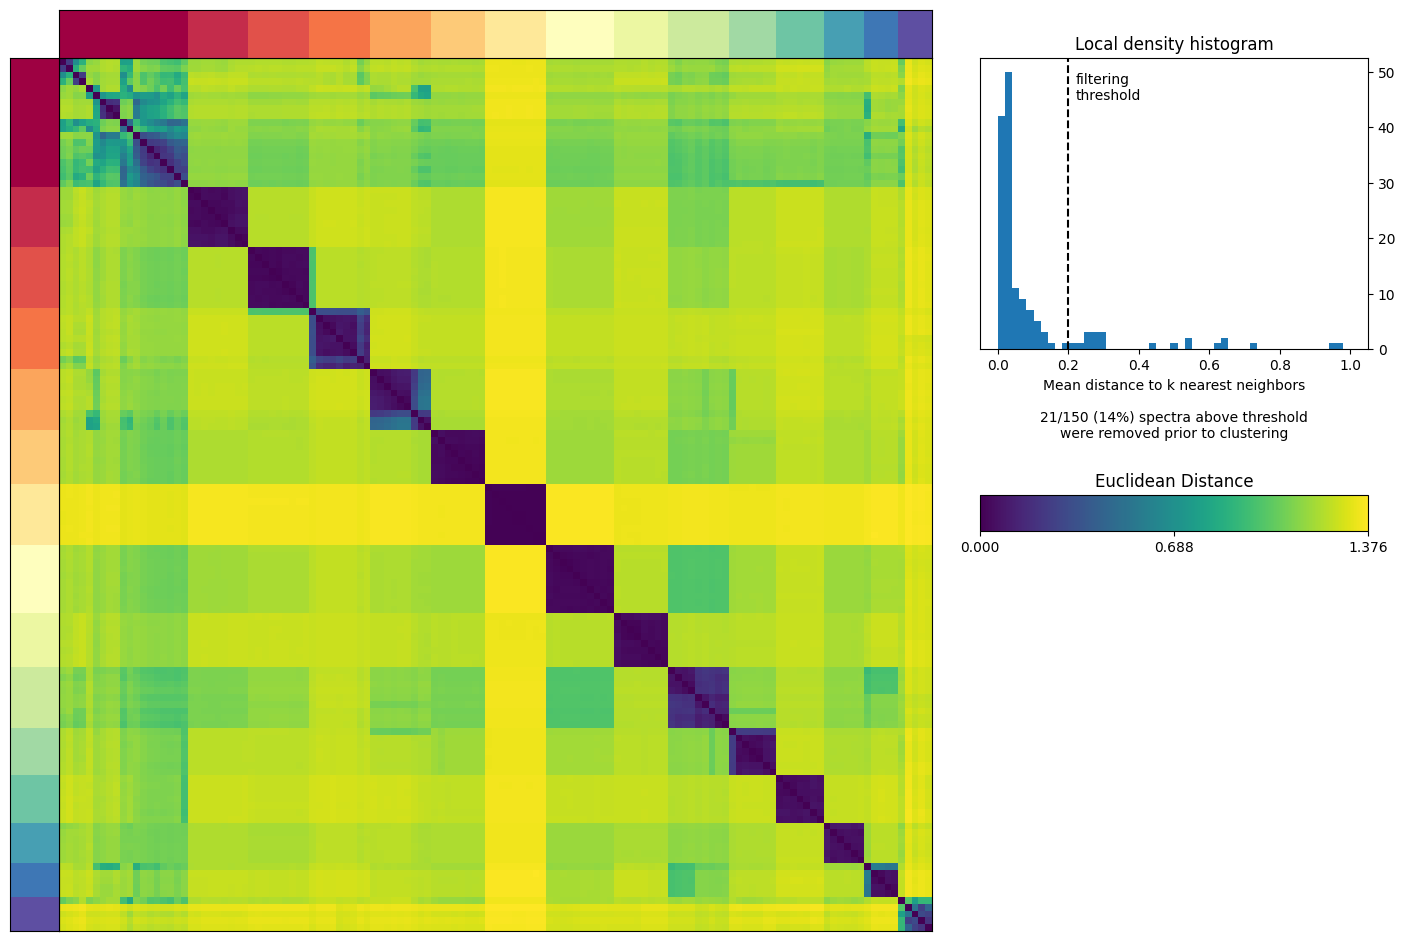

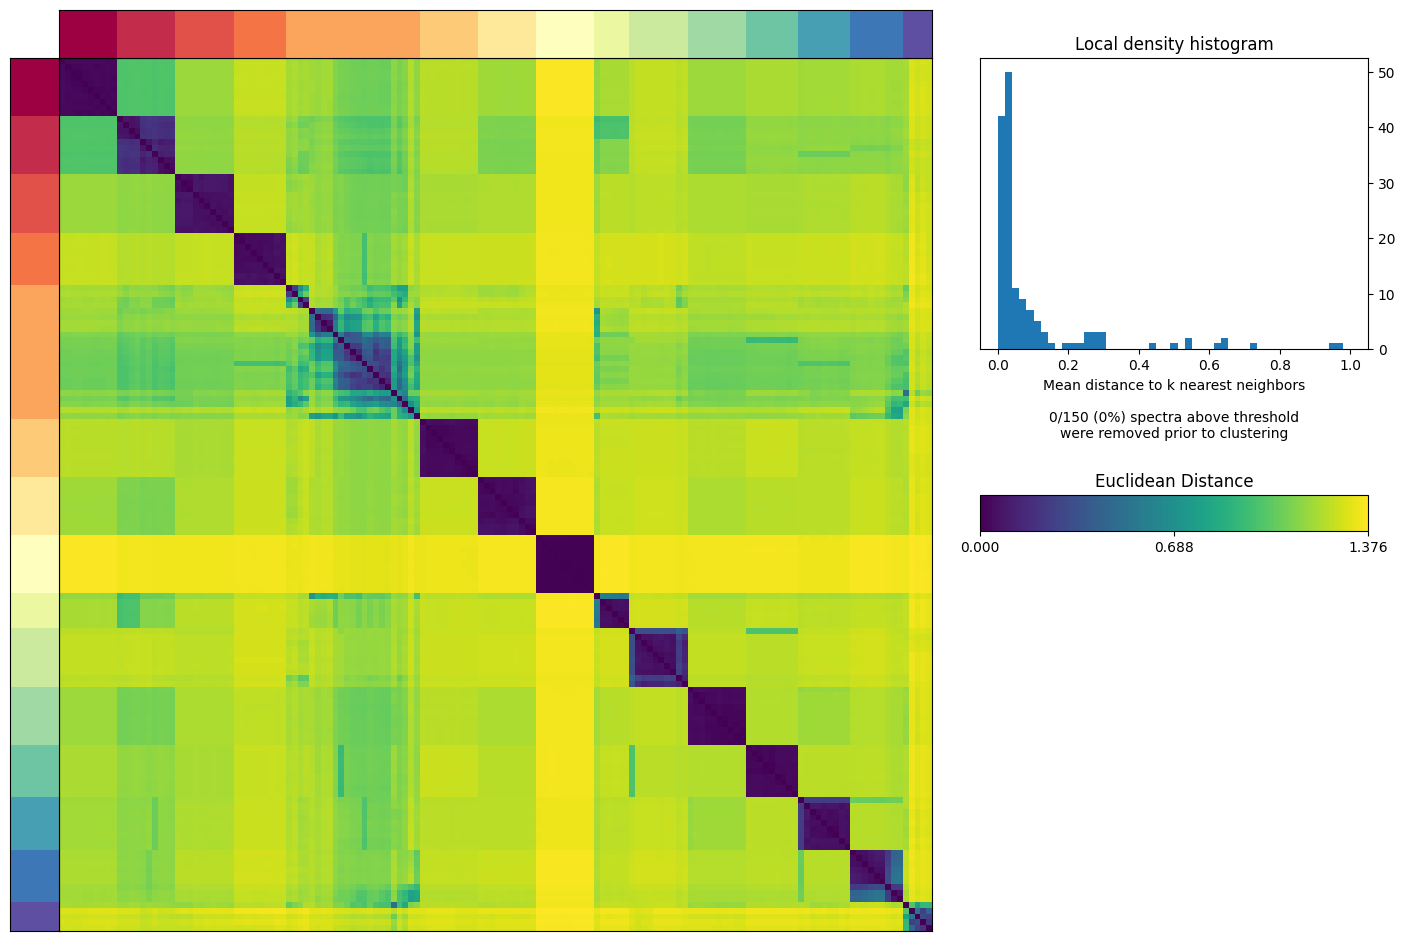

In [7]:
# Choose optimal thresholds by examining the mean distance distribution
run_cnmf_consensus(cnmf_obj, 
                   components=components, 
                   sel_thresh=sel_thresh)

In [ ]:
# Produce final decomp
sel_thresh = 0.2
run_cnmf_consensus(cnmf_obj, 
                   components=components, 
                   sel_thresh=[sel_thresh])

In [8]:
# Save all cNMF scores in separate mudata objects
sel_threshs = [0.2, 2.0]

for sel_thresh in sel_threshs:
    compile_results(output_directory,run_name,sel_thresh = sel_thresh, components=components)

In [9]:
# annotation for all K
gene_num = 300
os.makedirs((f'{output_directory}/{run_name}/Annotation'), exist_ok=True)


for k in components:
    df = pd.read_csv('{output_directory}/{run_name}/{run_name}.spectra.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)    
    overlap = get_top_indices_fast(df, gene_num=gene_num)
    annotate_genes_to_excel(overlap, f'{output_directory}/{run_name}/Annotation/{k}.xlsx')

INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_1': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_2': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_3': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_4': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_5': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_1': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_2': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_3': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_4': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_5': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_6': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_7': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_8': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_9': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_10': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_1': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_2': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_3': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_4': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_5': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_6': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_7': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_8': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_9': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_10': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_11': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_12': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_13': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_14': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-300 ...


Annotating column 'Program_15': 300 genes...


INFO:httpx:HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
INFO:biothings.client:Finished.
